In [1]:
import numpy as np
import healpy as hp


# use the CAMB cosmology that generated the matter power spectra
import camb

import glass.ext.camb


import matplotlib
import matplotlib.pyplot as plt

plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')
plt.rc('image', interpolation='none')


In [2]:
from src.cosmology import nla, glass_utils, levin, parameters, priors
from src.cosmology.map_shears import map_shears
from src.cosmology.gower_street import GowerStCosmologies

cosmo_loader = GowerStCosmologies('/home/asaoulis/projects/glass_transfer/kids-legacy-sbi/data/gower_st/PKDGRAV3_on_DiRAC_DES_330.csv')

/home/asaoulis/projects/glass_transfer/src/cosmology/gower_street.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [3]:
cosmo, pars, param_dict  = cosmo_loader.get_simulation_cosmology(200)

Note: redshifts have been re-sorted (earliest first)


## Setup some folders etc.

In [4]:
data_dir = '/home/asaoulis/projects/glass_transfer/kids-legacy-sbi/data'

### Define Cosmology Prior

In [5]:
# basic parameters of the simulation
nside = 512
n_ell = 20
# lmax = 300
lmax = 2*nside
lmin = 0


# intrinsic alignments params
ia_params = dict(
    a_ia = 5.74,
    b_ia = 0.44,
    f_red = np.array([0.15, 0.2, 0.17, 0.24, 0.19, 0.03]),
    log10_M_eff = np.array([11.69, 12.46, 12.76, 12.93, 13.08, 13.21]),
)

# Random settings
seed_num = 12


# Levin settings
levin_params = dict(
    kmax=500.0,
    kmin=1e10,
    nmin=50,
    npoint=3,
    nmax=200
)



In [6]:
#Get the result
results = camb.get_results(pars)
results.calc_power_spectra(pars)
k, z_grid, pk = results.get_nonlinear_matter_power_spectrum()
chi_grid = results.angular_diameter_distance(z_grid) * (1+z_grid) # the correpsonding comoving distances 
extended_k, extended_pk = levin.extrapolate_section(k, z_grid, pk, **levin_params)


In [7]:
# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0.000, 3.1, dx=200.)
ws, lp, ell = levin.setup_levin_power(zb, z_grid, chi_grid, extended_k, extended_pk, results, pars)

In [8]:
n_los_chi = 1000 #define the integration limits here
los_z_integration = np.linspace(zb[0], zb[-1], n_los_chi)
los_chi_integration = np.asarray(results.angular_diameter_distance(los_z_integration) * (1+los_z_integration) )

In [ ]:
shift_nz = True # whether to shift the n(z) by the biases and covariance provided
# Instrinsic galaxy shape dispersion per tomographic bin
#Multiplicative shear bias
m_bias = np.array([-0.022869, -0.015966, -0.011331, 0.019870, 0.029506, 0.044535 ])
m_bias_unc = np.array([0.005630, 0.005900, 0.007111, 0.006773, 0.007598, 0.008902 ])

# Additive shear bias
c_1_bias_north = np.array([3.372, 8.941, 4.523, 4.722, 6.658, 4.224])*1e-4
c_1_bias_north_unc = np.array([1.528, 1.442, 1.747, 1.713, 1.887, 2.252])*1e-4
c_2_bias_north = np.array([7.941, 8.852, 4.533, 5.368, 5.532, 10.26])*1e-4
c_2_bias_north_unc = np.array([1.442, 1.642, 1.777, 1.665, 1.890, 2.400])*1e-4

c_1_bias_south = np.array([-3.398, -9.536, -4.755, -4.532, -6.117, -3.717])*1e-4
c_1_bias_south_unc = np.array([1.626, 1.519, 1.835, 1.653, 1.910, 2.151])*1e-4
c_2_bias_south = np.array([-8.002, -6.026, -4.766, -5.152, -5.082, -9.027])*1e-4
c_2_bias_south_unc = np.array([1.572, 1.590, 1.731, 1.594, 1.834, 2.282])*1e-4

# Galaxy density in each tomographic bin
n_arcmin2 = np.array([1.7698, 1.6494, 1.4974, 1.4578, 1.3451, 1.0682]) # per arcmin^2

# Instrinsic galaxy shape dispersion per tomographic bin
sigma_e = np.array([0.2772, 0.2716, 0.2899, 0.2619, 0.2802, 0.3002])


# Tomographic redshift bins
nbins = 6

ztomo = [
    (0.10, 0.42),
    (0.42, 0.58),
    (0.58, 0.71),
    (0.71, 0.90),
    (0.90, 1.14),
    (1.14, 2.00)
]

tomo_nz = np.zeros((nbins, n_los_chi))

ztomo_label = [
    ('0.10', '0.42'),
    ('0.42', '0.58'),
    ('0.58', '0.71'),
    ('0.71', '0.90'),
    ('0.90', '1.14'),
    ('1.14', '2.00')
]

if shift_nz:
    dz_biases = np.loadtxt(f'{data_dir}/nofzs/dz/Nz_biases.txt')
    dz_cov = np.loadtxt(f'{data_dir}/nofzs/dz/Nz_covariance.txt')
    shift_dz_realised = np.random.multivariate_normal(mean=dz_biases, cov=dz_cov, size=1)[0]
    

for i in range(nbins):
    hdu = np.loadtxt(f'{data_dir}/nofzs/nz/BLINDSHAPES_KIDS_Legacy_NS_shear_noSG_noWeiCut_newCut_blindABC_A1_rmcol_filt_lab_filt_lab_filt_PSF_RAD_calc_filt_ZB{str(ztomo_label[i][0]).split(".")[0]}p{str(ztomo_label[i][0]).split(".")[1]}t{str(ztomo_label[i][1]).split(".")[0]}p{str(ztomo_label[i][1]).split(".")[1]}_calib_goldwt_Nz.ascii').T
    z = hdu[0]
    if shift_nz:
        z_shifted = z - shift_dz_realised[i]
        n_z = np.interp(z, z_shifted, hdu[1])
        zmid = z[:-1] + 0.5*(z[1:] - z[:-1])
        dndz_interpolated = np.interp(los_z_integration, zmid, n_arcmin2[i]*n_z[:-1]/np.trapezoid((n_z[:-1]), zmid))
        tomo_nz[i] = np.clip(dndz_interpolated, 0, None)    
    else:
        zmid = z[:-1] + 0.5*(z[1:] - z[:-1])
        dndz_interpolated = np.interp(los_z_integration, zmid, n_arcmin2[i]*hdu[1][:-1]/np.trapezoid(hdu[1][:-1], zmid))
        tomo_nz[i] = np.clip(dndz_interpolated, 0, None)

# Read in the KiDS-Legacy mask
kids_mask = hp.read_map(f'{data_dir}/masks/KiDS_Legacy_N_healpix_1024_frac_withAstrom.fits') + hp.read_map(f'{data_dir}/masks/KiDS_Legacy_S_healpix_1024_frac_withAstrom.fits')
vis = mask = hp.ud_grade(kids_mask, nside_out=nside, order_in='RING', order_out='RING', power=-2)


In [10]:
# Realised shear bias

m_bias_realised = np.array([float(np.random.normal(m_bias[i], m_bias_unc[i], 1)) for i in range(len(m_bias))])
c1_bias_north_realised = np.array([float(np.random.normal(c_1_bias_north[i], c_1_bias_north_unc[i], 1)) for i in range(len(c_1_bias_north))])
c2_bias_north_realised = np.array([float(np.random.normal(c_2_bias_north[i], c_2_bias_north_unc[i], 1)) for i in range(len(c_2_bias_north))])
c1_bias_south_realised = np.array([float(np.random.normal(c_1_bias_south[i], c_1_bias_south_unc[i], 1)) for i in range(len(c_1_bias_south))])
c2_bias_south_realised = np.array([float(np.random.normal(c_2_bias_south[i], c_2_bias_south_unc[i], 1)) for i in range(len(c_2_bias_south))])


/tmp/ipykernel_189190/3512286738.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m_bias_realised = np.array([float(np.random.normal(m_bias[i], m_bias_unc[i], 1)) for i in range(len(m_bias))])
/tmp/ipykernel_189190/3512286738.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c1_bias_north_realised = np.array([float(np.random.normal(c_1_bias_north[i], c_1_bias_north_unc[i], 1)) for i in range(len(c_1_bias_north))])
/tmp/ipykernel_189190/3512286738.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this

In [11]:
rotation_angles=[0, 180]
num_shape_noise_realisations=1


In [12]:
from src.cosmology.simulators import GowerStreetSimulator

data_dir = '/share/gpu5/asaoulis/gowerstreet/sim00200'

kwargs = {
    'cosmo': cosmo,
    'los_z_integration': los_z_integration,
    'tomo_nz': tomo_nz,
    'galaxy_bias': 1.0,
    'shear_bias_params': {
        'm_bias': m_bias_realised,
        'c1_north': c1_bias_north_realised,
        'c2_north': c2_bias_north_realised,
        'c1_south': c1_bias_south_realised,
        'c2_south': c2_bias_south_realised
    },
    'nla_params': ia_params,
    'sigma_e': sigma_e,
    'mask': mask,
    'nside': nside,
    'nbins': nbins,
    'rng': np.random.default_rng(seed=seed_num)
}

simulator = GowerStreetSimulator(data_dir, **kwargs)
catalogues = simulator.run(rotation_angles=rotation_angles, num_shape_noise_realisations=num_shape_noise_realisations)


loading step 100 with zeff of 0.01, file run.00100.lightcone.npy
Processing shell 1/75...


/home/asaoulis/projects/glass_transfer/src/cosmology/simulators.py:172: UserWarning: when sampling galaxies, redshifts_from_nz() is often not the function you want. Try redshifts() instead. Use warn=False to suppress this warning.
  gal_z = glass.galaxies.redshifts_from_nz(


Shell 1/75 processed in 3.18 seconds.
loading step 99 with zeff of 0.02, file run.00099.lightcone.npy
Processing shell 2/75...
Shell 2/75 processed in 2.53 seconds.
loading step 98 with zeff of 0.03, file run.00098.lightcone.npy
Processing shell 3/75...
Shell 3/75 processed in 2.56 seconds.
loading step 97 with zeff of 0.04, file run.00097.lightcone.npy
Processing shell 4/75...
Shell 4/75 processed in 2.55 seconds.
loading step 96 with zeff of 0.05, file run.00096.lightcone.npy
Processing shell 5/75...
Shell 5/75 processed in 2.55 seconds.
loading step 95 with zeff of 0.06, file run.00095.lightcone.npy
Processing shell 6/75...
Shell 6/75 processed in 2.57 seconds.
loading step 94 with zeff of 0.07, file run.00094.lightcone.npy
Processing shell 7/75...
Shell 7/75 processed in 2.60 seconds.
loading step 93 with zeff of 0.08, file run.00093.lightcone.npy
Processing shell 8/75...
Shell 8/75 processed in 2.62 seconds.
loading step 92 with zeff of 0.10, file run.00092.lightcone.npy
Processin

In [ ]:
import h5py
import numpy as np
from pathlib import Path

def save_results_h5(filename, cat_idx, cls_results, pixelised_results, cosmo_dict):
    """
    Save cls_results, pixelised_results, and cosmo_dict into an HDF5 file.
    The output filename is <filename> with '_{cat_idx}.h5' before the extension.
    """
    # Ensure Path object
    filename = Path(filename)
    outname = filename.with_name(f"{filename.stem}_{cat_idx}{filename.suffix}")

    def _save_dict(h5group, dictionary):
        """Recursively save nested dicts into HDF5 groups/datasets."""
        for key, value in dictionary.items():
            if isinstance(value, dict):
                subgroup = h5group.create_group(str(key))
                _save_dict(subgroup, value)
            else:
                # Convert to numpy if needed
                arr = np.array(value)
                h5group.create_dataset(str(key), data=arr)

    with h5py.File(outname, "w") as f:
        # Save cls_results
        cls_group = f.create_group("cls_results")
        _save_dict(cls_group, cls_results)

        # Save pixelised_results
        pix_group = f.create_group("pixelised_results")
        _save_dict(pix_group, pixelised_results)

        # Save cosmo_dict
        cosmo_group = f.create_group("cosmo_dict")
        _save_dict(cosmo_group, cosmo_dict)

    print(f"Results saved to {outname}")


In [59]:
!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.5 MB/s eta 0:00:00


In [54]:
from src.cosmology.manip_cls import denoise_shear_cls, unmix_shear_cl, cat2mask, maskcls, compute_cl_bandpowers
from src.cosmology.pixelise_maps import get_patch_values
from src.cosmology.map_shears  import make_alm_shear_convergence

def process_cls(catalogue, nbins, nside, alm, alm_rand, lower_lscale, upper_lscale, nbands):
    shear_cls_noiseless = denoise_shear_cls(nbins, alm, alm_rand, lmax)
    bin_masks = cat2mask(catalogue, nbins, nside)
    bin_mask_cls = maskcls(bin_masks, lmax=int(1.5*lmax), nbins=nbins)
    realised_unmixed_shear_cls = unmix_shear_cl(num_bins = nbins, shear_cls = shear_cls_noiseless, mask_cl = bin_mask_cls, lmin = lmin, lmax = lmax)
    realised_unmixed_shear_cls_cut = realised_unmixed_shear_cls[:, :, :, lower_lscale:upper_lscale+1]
    cll_bands, bandpowers = compute_cl_bandpowers(realised_unmixed_shear_cls_cut, nbins, lower_lscale, upper_lscale, nbands)
    return realised_unmixed_shear_cls, cll_bands, bandpowers

lower_lscale = 76
upper_lscale = 948
nbands = 20
named_patches = {
    "south":(12, -31, 85, 10),     # (lon_center, lat_center, lon_range, lat_range)
    "north":(-178, 0, 112, 10)
}
patches = list(named_patches.values())
rotation_values = [rot for rot in rotation_angles for _ in range(num_shape_noise_realisations)]


for cat_idx, catalogue in enumerate(catalogues):
    ang = rotation_values[cat_idx]
    cls_results = {cl_type:{} for cl_type in ['full', 'north', 'south']}

    alm, alm_rand, shear, E, B  = make_alm_shear_convergence(catalogue, m_bias_realised, nbins, nside, lmax)
    realised_unmixed_shear_cls, cll_bands, bandpowers = process_cls(catalogue, nbins, nside, alm, alm_rand, lower_lscale, upper_lscale, nbands, )
    map_types = {"shear_real": shear.real, "shear_imag": shear.imag, "E":E, "B":B}
    pixelised_results = {name:{} for name in map_types.keys()}
    for name, cat_data in map_types.items():
        pixelised_tomobin_patches = get_patch_values(cat_data, patches, nside, ang)
        for patch_idx, patch_name in enumerate(named_patches.keys()):
            pixelised_results[name][patch_name] = pixelised_tomobin_patches[patch_idx]


    cls_results['full'] = {"cls": realised_unmixed_shear_cls, "bandpowers":bandpowers, "bandpower_ls":cll_bands}

    patch_defs = {
        "north": (np.abs(catalogue['DEC']) < 15),
        "south": (np.abs(catalogue['DEC']) >= 15),
    }
    for patch_name, selector in patch_defs.items():
        subcat = catalogue[selector]
        alm, alm_rand, _, _, _  = make_alm_shear_convergence(subcat, m_bias_realised, nbins, nside, lmax, compute_convergence=False)
        realised_unmixed_shear_cls, cll_bands, bandpowers = process_cls(subcat, nbins, nside, alm, alm_rand, lower_lscale, upper_lscale, nbands, )
        cls_results[patch_name] = {"cls": realised_unmixed_shear_cls, "bandpowers":bandpowers, "bandpower_ls":cll_bands}


    

Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching holes
Patching h

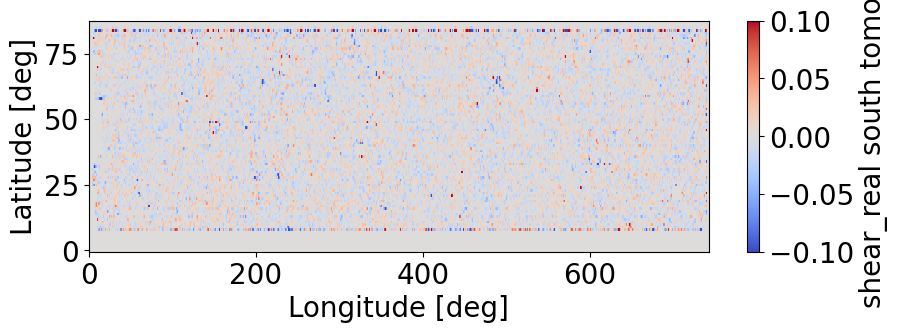

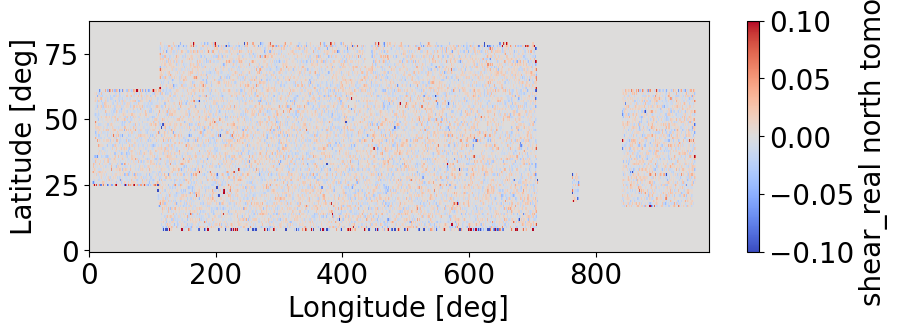

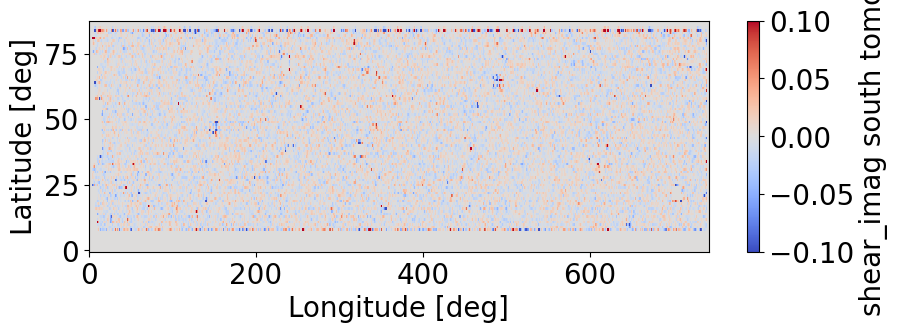

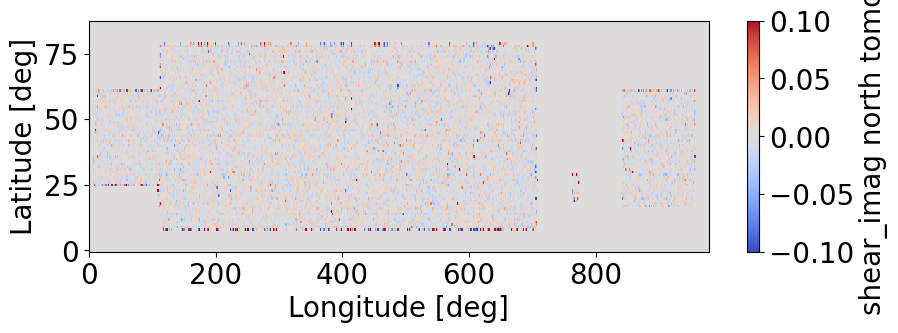

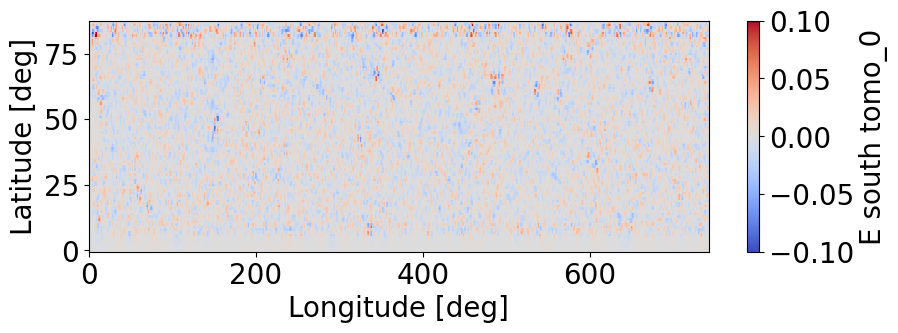

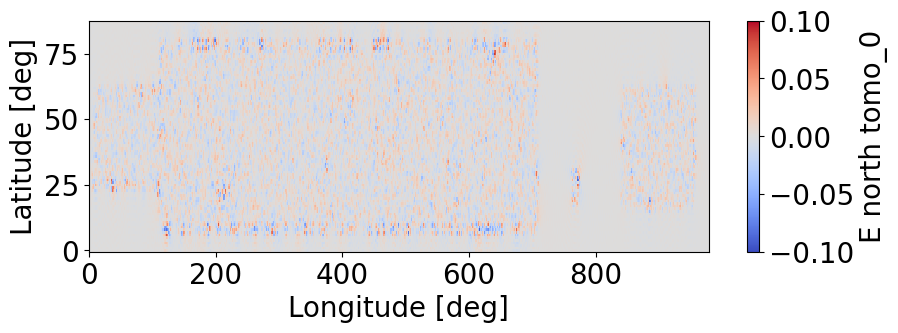

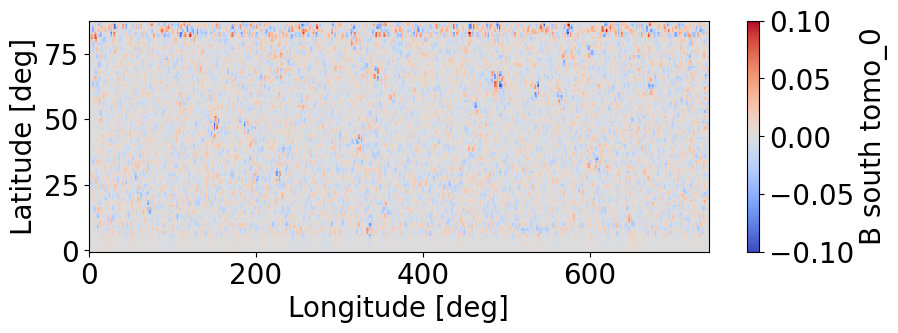

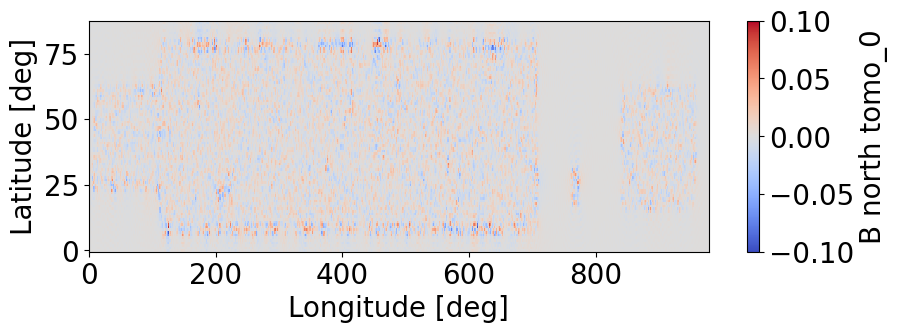

In [55]:
def plot_patch(values, label):
    plt.figure(figsize=(10, 3))
    plt.imshow(values[::-1, ::-1],
               origin="lower", cmap="coolwarm", vmin=-0.1, vmax=0.1, aspect="auto")
    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.colorbar(label=f"{label}")
    plt.show()

for field_type, field_dict in pixelised_results.items():
    for patch_name, values in field_dict.items():
        plot_patch(values[0],f"{field_type} {patch_name} tomo_0" )

In [56]:
pars.min_l = 2
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=los_z_integration, W=tomo_nz[i], source_type="lensing") for i in range(len(tomo_nz))

]
results = camb.get_results(pars)
theory_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

full


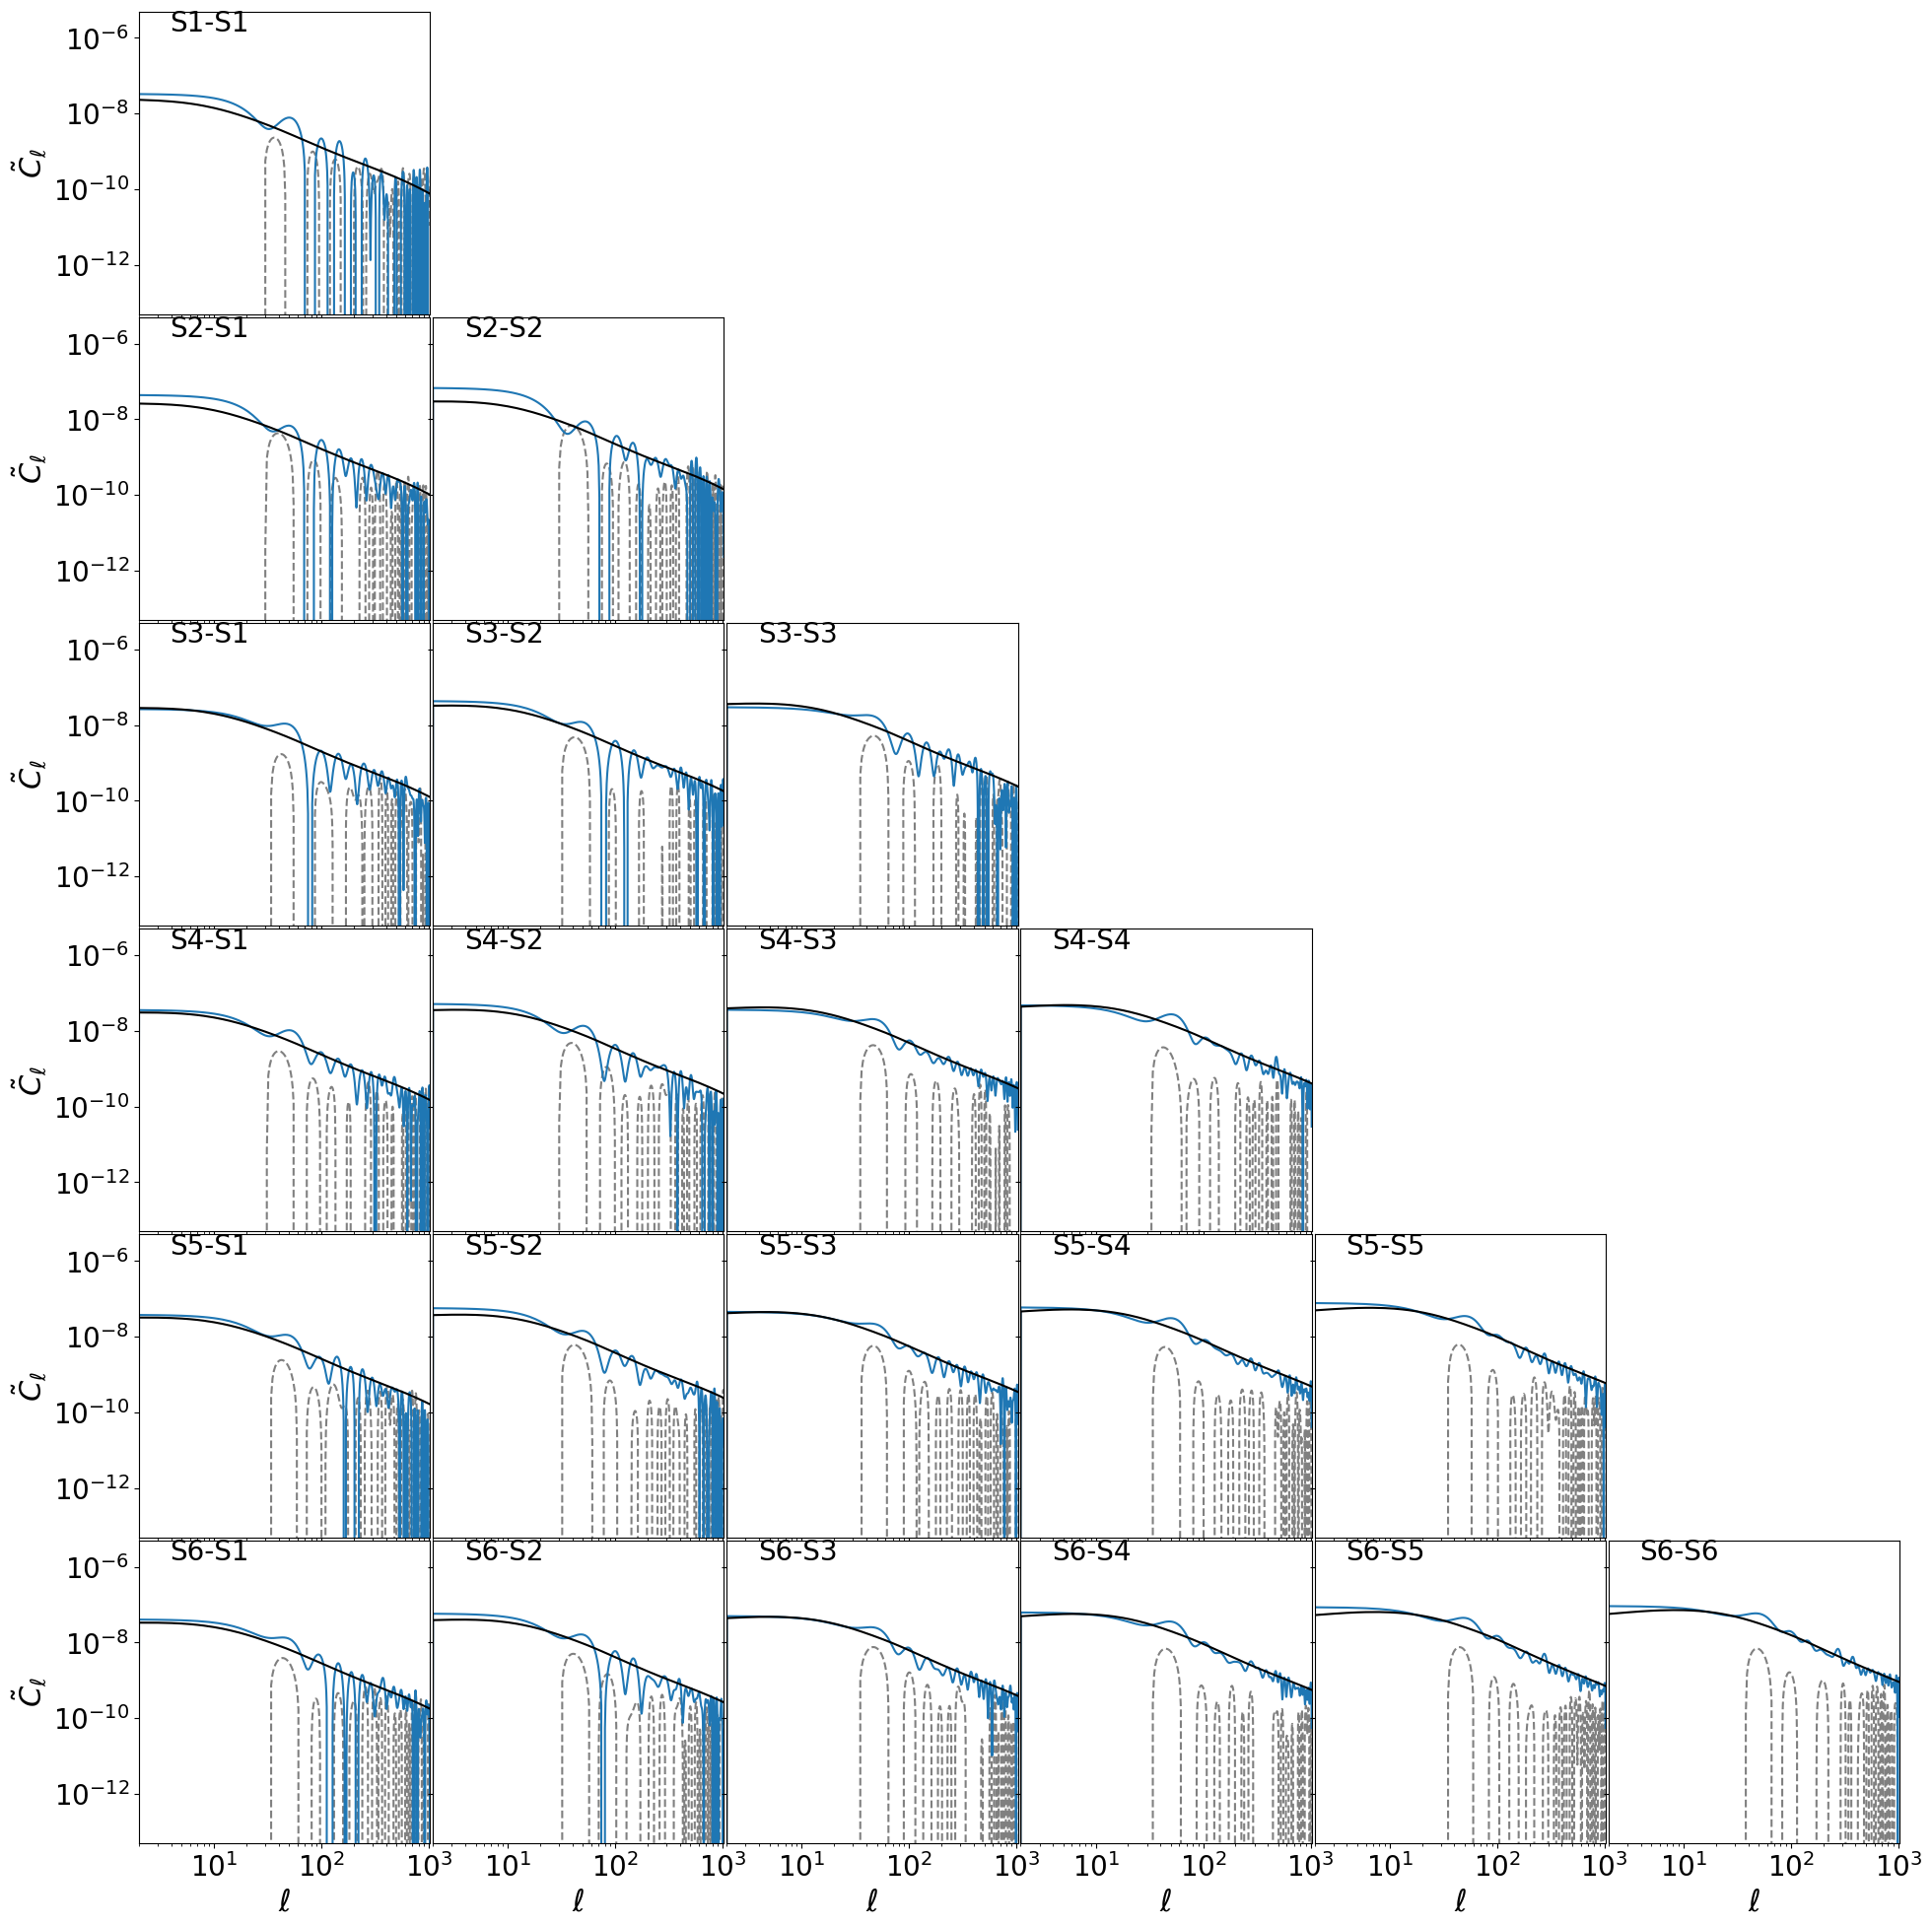

north


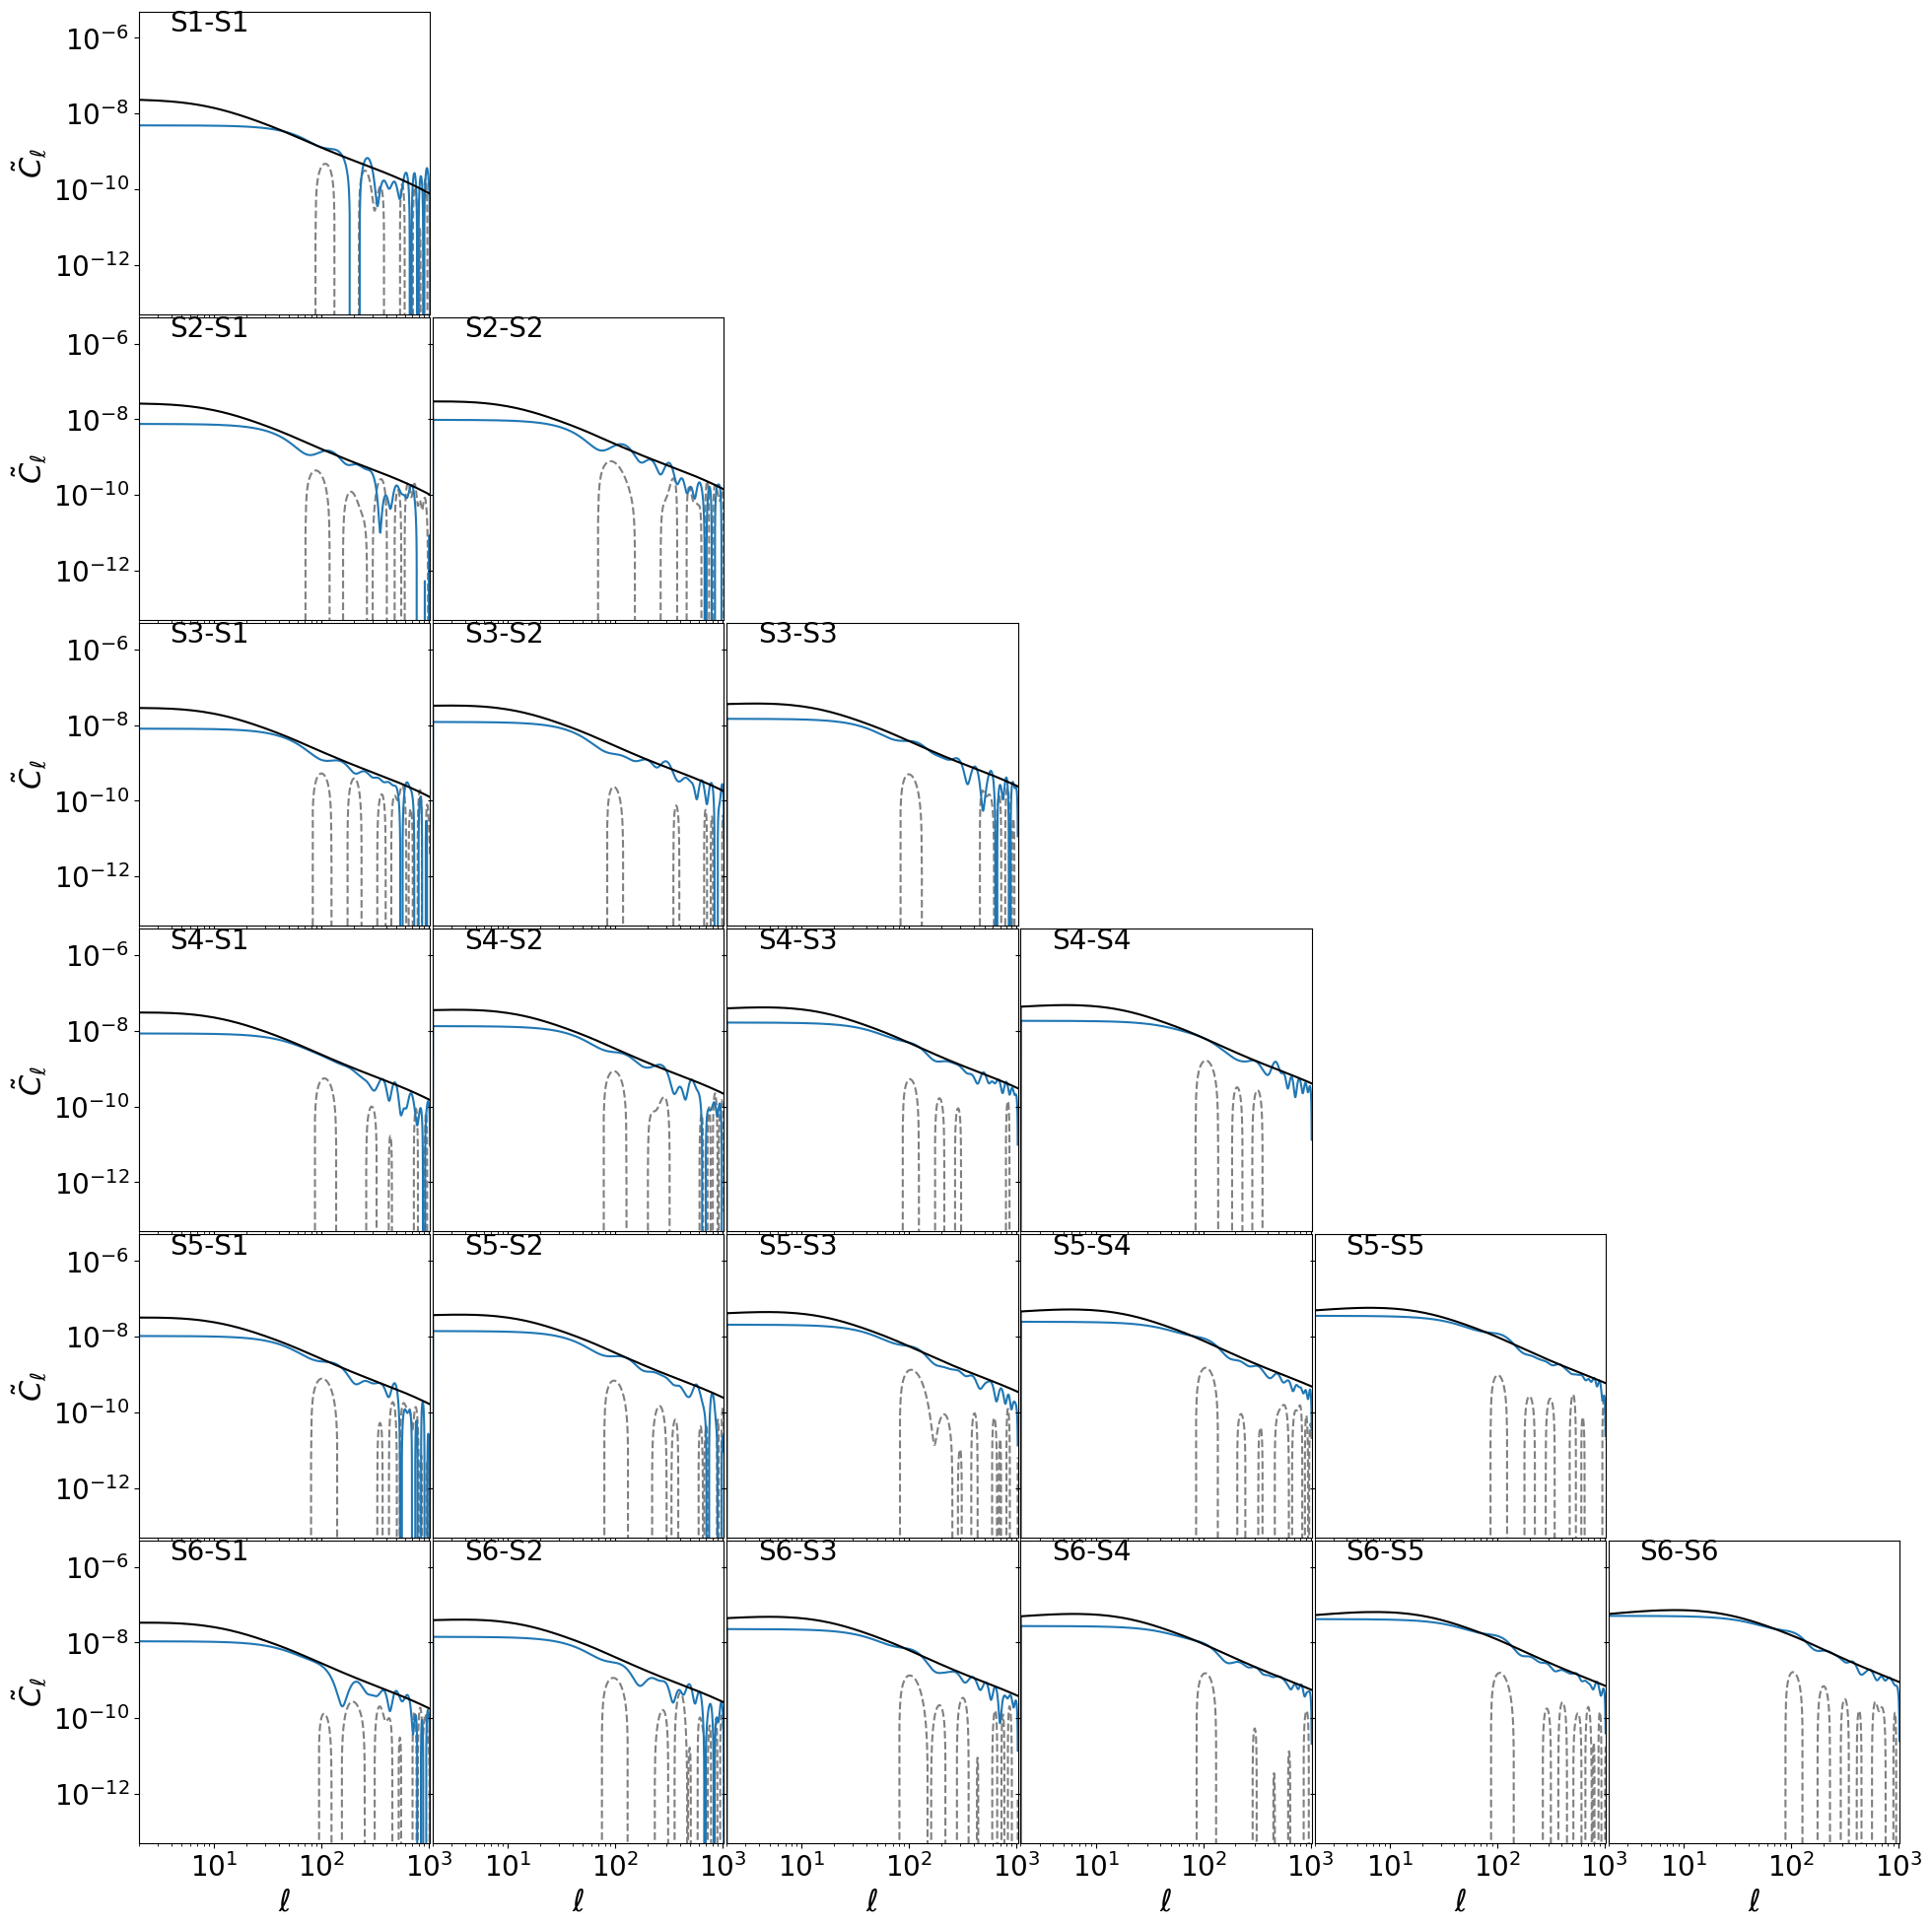

south


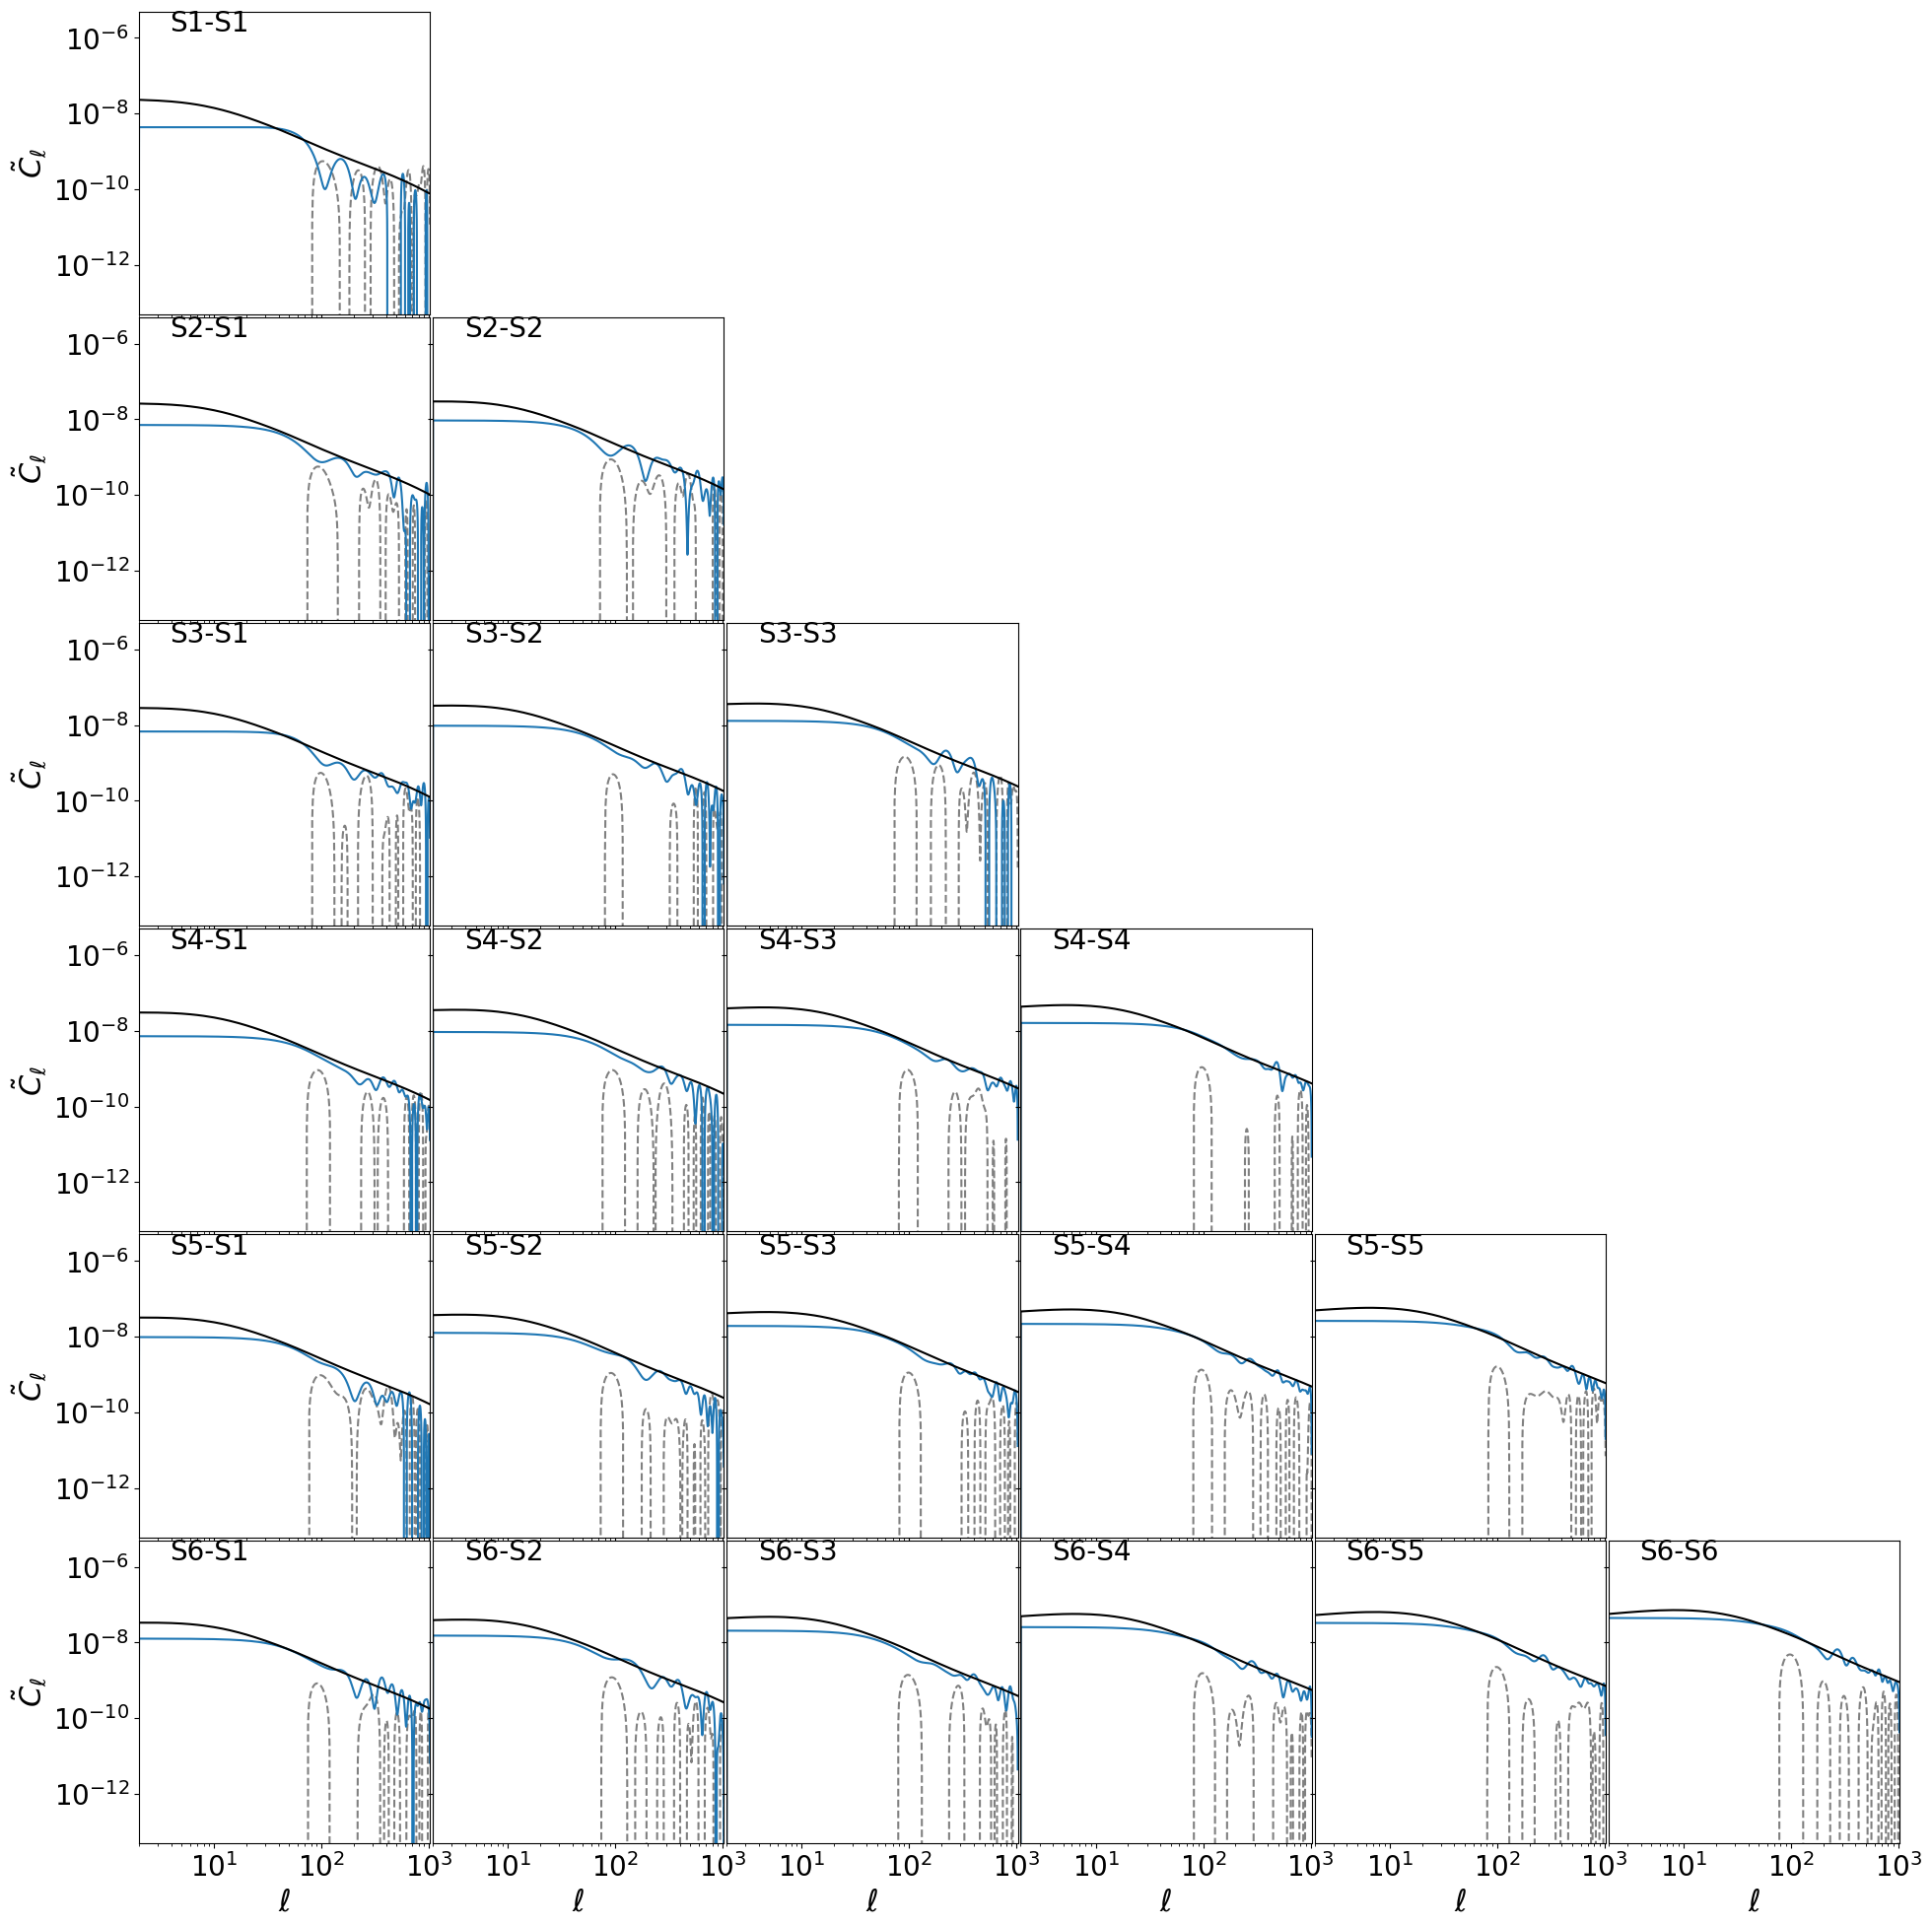

In [57]:
matplotlib.rcParams.update({'font.size': 20})
for cl_type, cl_results in cls_results.items():
    realised_unmixed_shear_cls = cl_results['cls']
    print(cl_type)
    counter=0
    fig, axs = plt.subplots(nbins, nbins, figsize=(20, 20))
    xmin, xmax = 2, lmax
    ymin, ymax = 5e-14, 5e-6

    for i in range(0, nbins):
        for j in range(0, nbins):
            if i<j:
                axs[i, j].axis('off')
            else:
                x = 10**(np.log10(xmin)) + 0.7*(np.log10(xmax) - np.log10(xmin))
                y = ymin + 0.3*(ymax - ymin)

                axs[i, j].plot(np.arange(0, lmax+1), realised_unmixed_shear_cls[i][j][1], c='grey', ls = '--')
                axs[i, j].plot(np.arange(0, lmax+1), realised_unmixed_shear_cls[i][j][0], c='C0')
                axs[i, j].plot(np.arange(0, lmax+1), theory_cls[f'W{i+1}xW{j+1}'], c='black')

                axs[i, j].set_xscale('log')
                axs[i, j].set_yscale('log')
                axs[i, j].set_xlim([xmin, xmax])
                axs[i, j].set_ylim([ymin, ymax])
                label = 'S'+str(i+1)+'-S'+str(j+1)
                axs[i, j].text(x, y, label)

                if i == nbins - 1:
                    axs[i, j].set_xlabel(r'$\ell$', fontsize=22)
                else:
                    plt.setp(axs[i, j].get_xticklabels(), visible=False)
                
                if j == 0:
                    axs[i, j].set_ylabel(r'$\tilde{C}_{\ell}$', fontsize=22)
                else:
                    plt.setp(axs[i, j].get_yticklabels(), visible=False)

                counter += 1

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

full


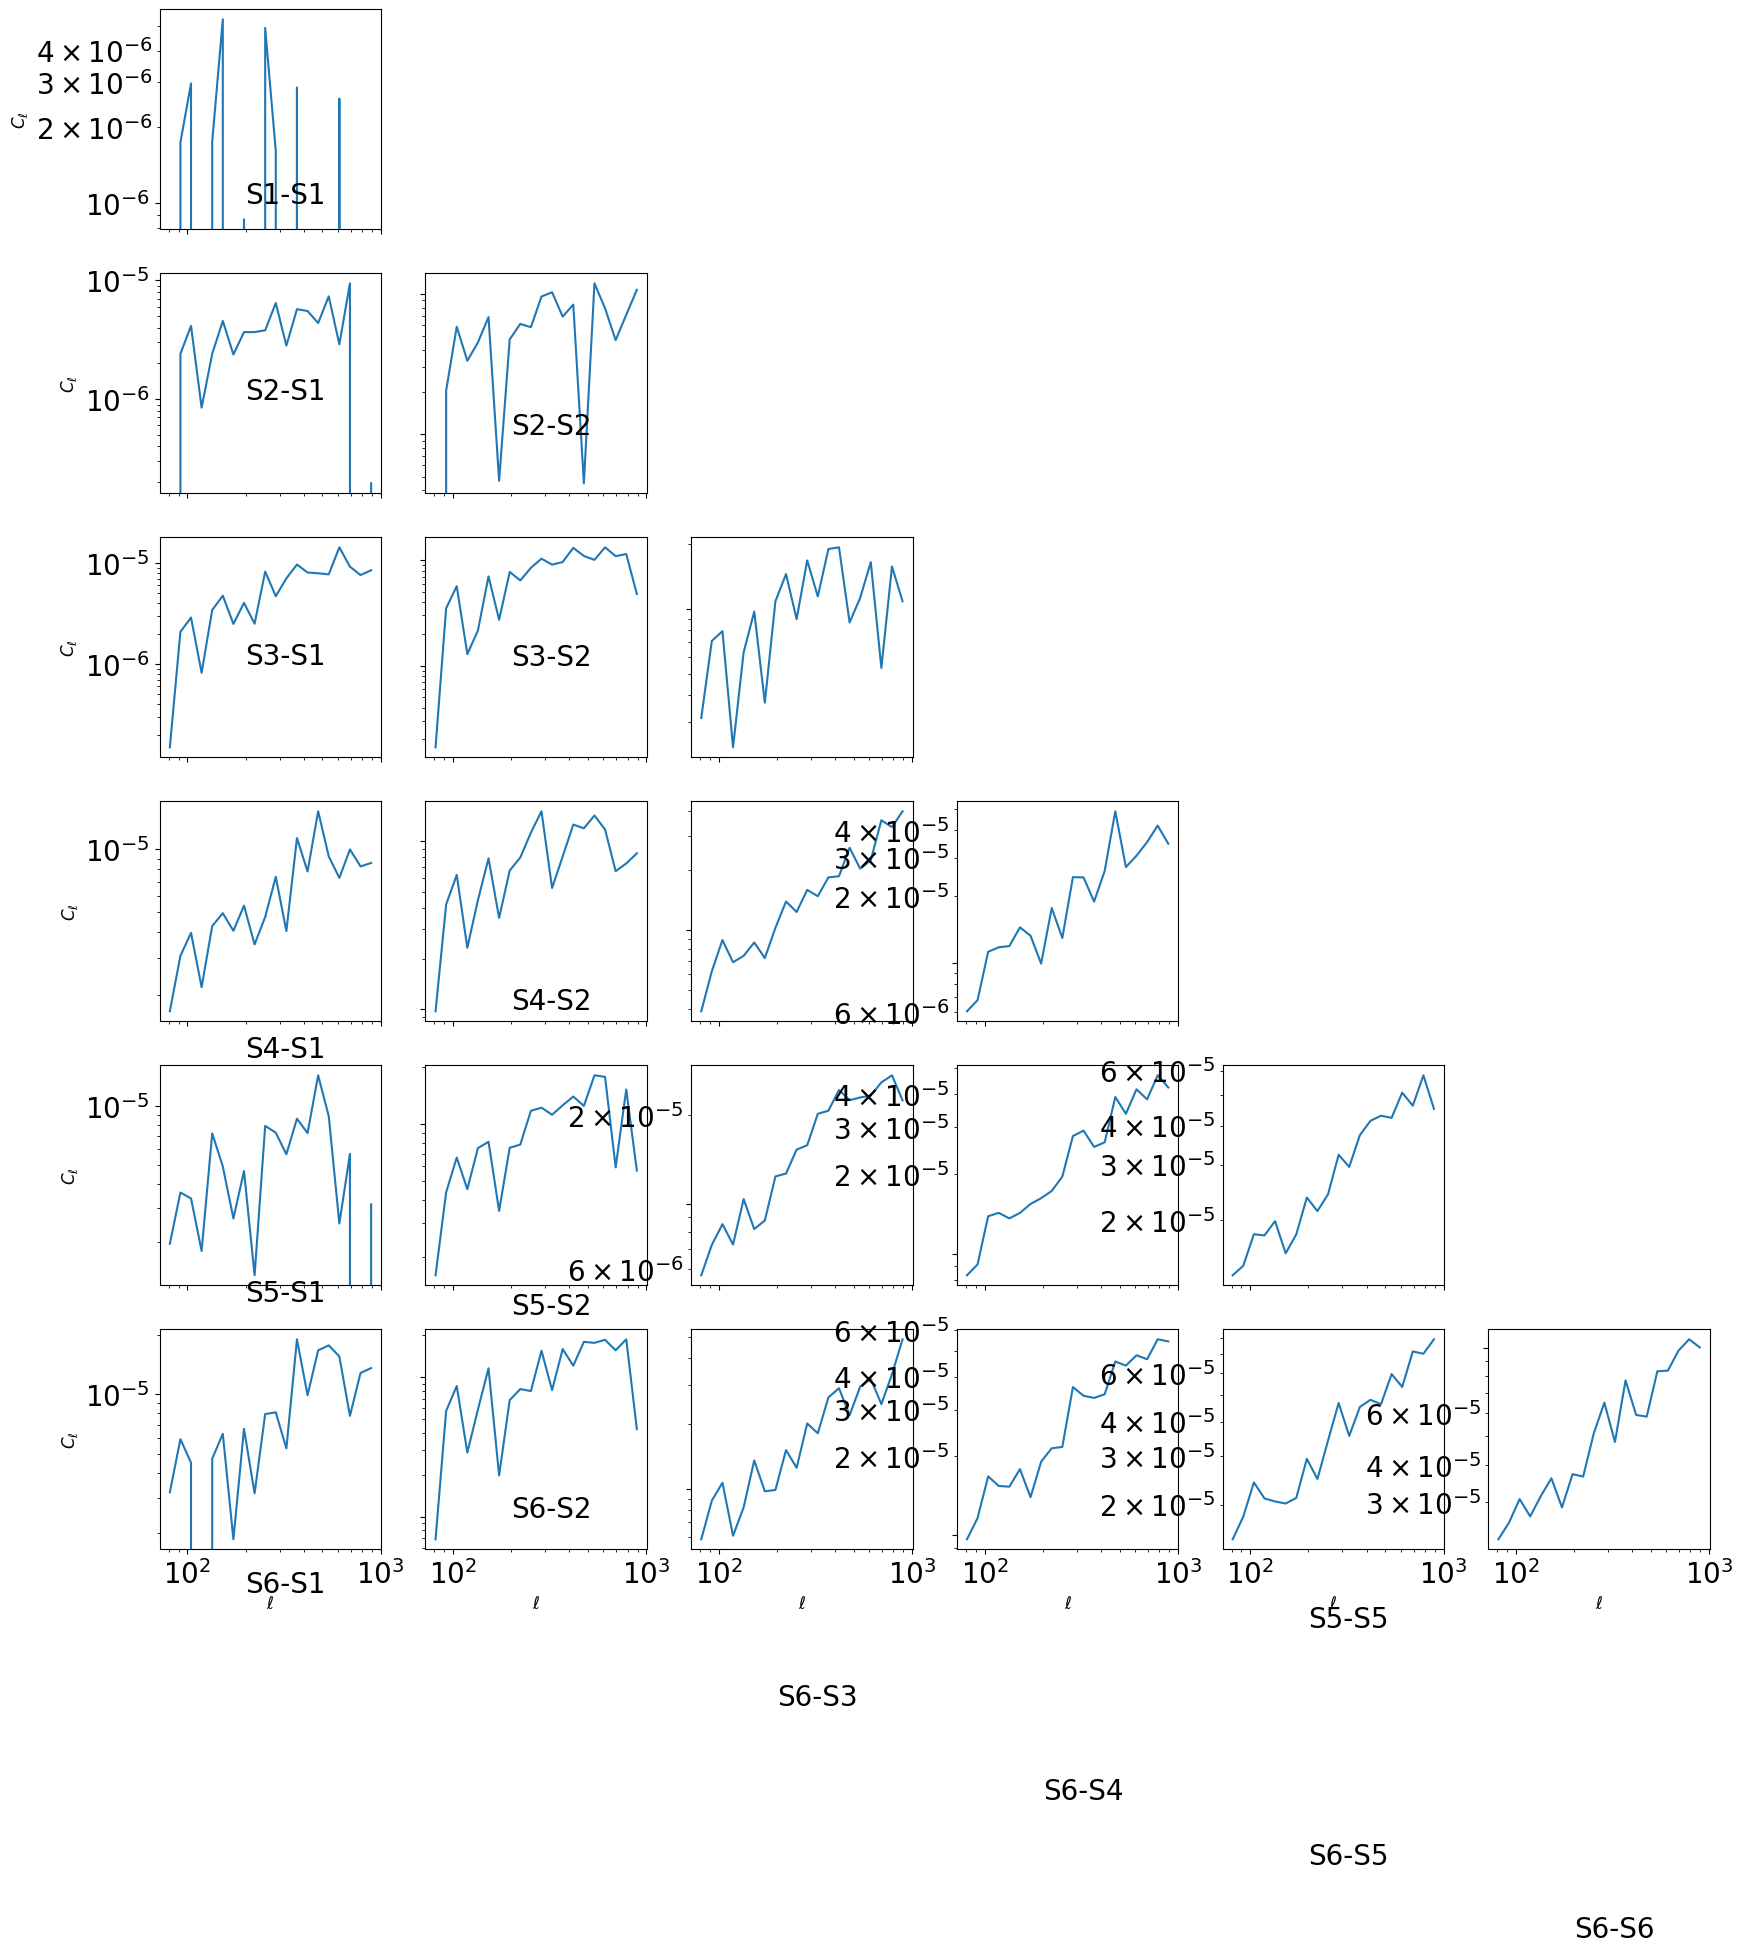

north


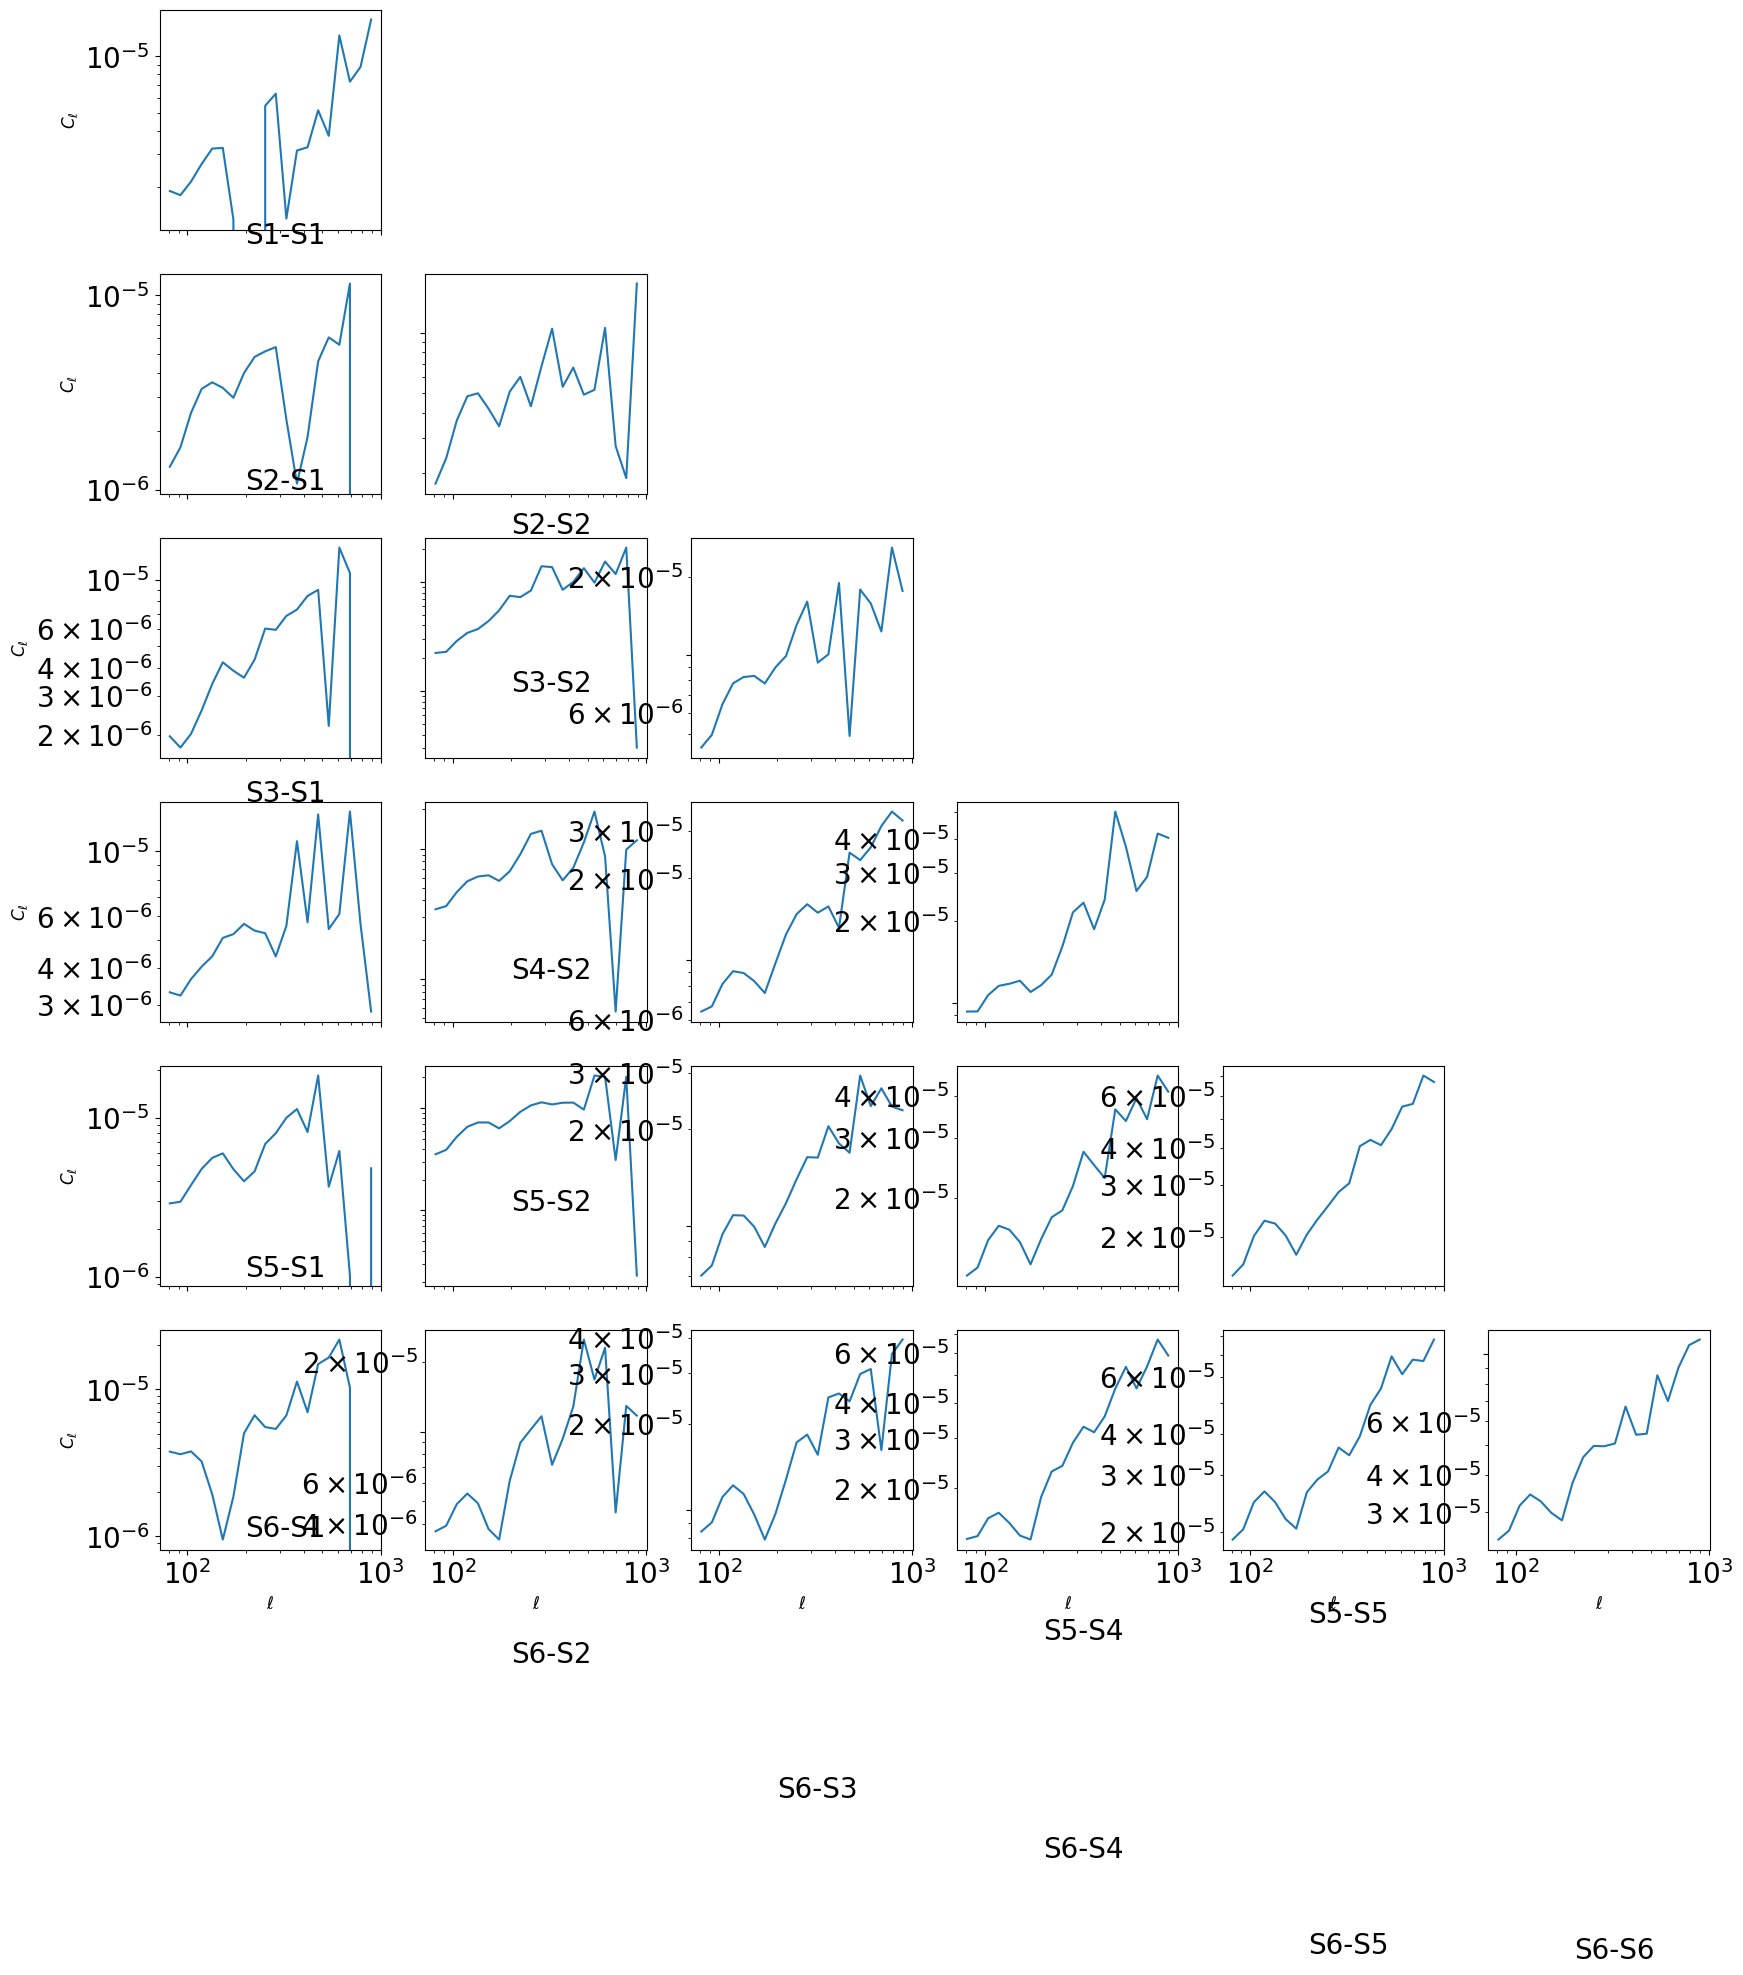

south


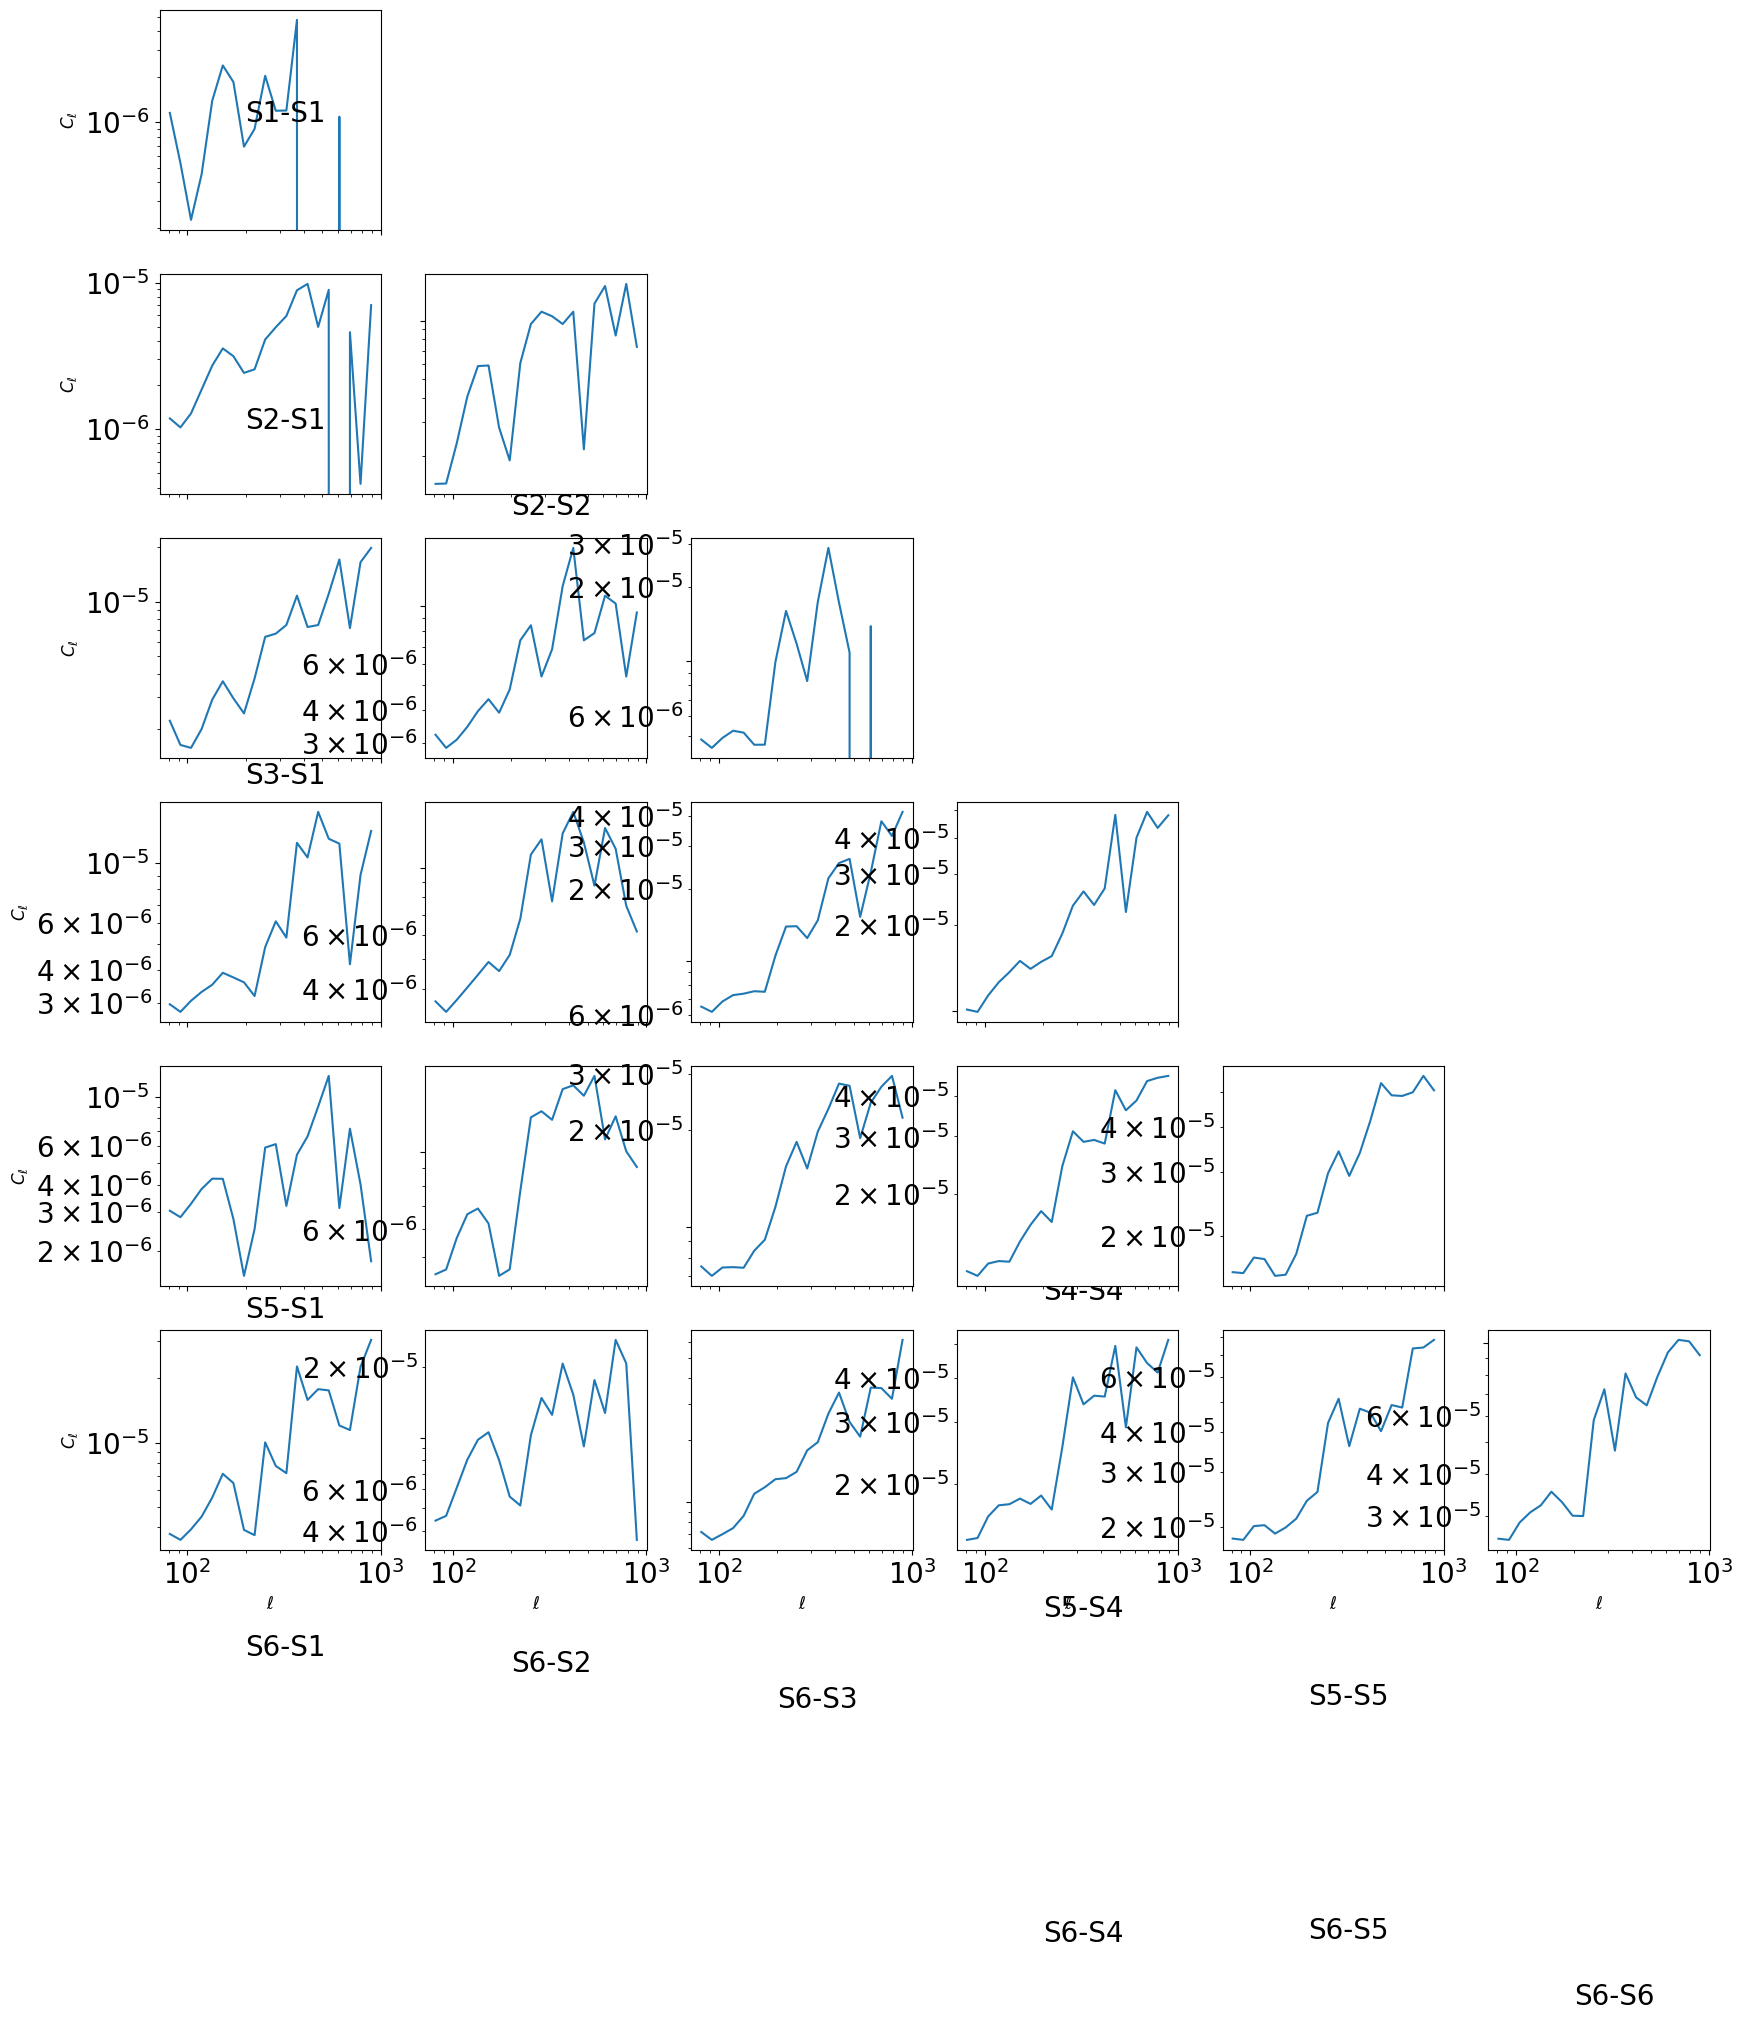

In [58]:
for cl_type, cl_results in cls_results.items():
    print(cl_type)
    cll_bands = cl_results['bandpower_ls']
    bandpowers = cl_results["bandpowers"]
    fig, ax = plt.subplots(nbins, nbins, figsize=(20,20))
    for i in range(nbins):
        for j in range(nbins):
            if i<j:
                ax[i, j].axis('off')
            else:
                label = 'S'+str(i+1)+'-S'+str(j+1)
                ax[i, j].plot(cll_bands, bandpowers[int(i*(i+1)/2 + j)], label=label)
                ax[i, j].set_xscale('log')
                ax[i, j].set_yscale('log')
                # ax[i, j].set_xlim([lower_lscale, upper_lscale])
                # ax[i, j].set_ylim([5e-14, 5e-6])
                ax[i, j].text(200, 1e-6, label)

                if i == nbins - 1:
                    ax[i, j].set_xlabel(r'$\ell$', fontsize=12)
                else:
                    plt.setp(ax[i, j].get_xticklabels(), visible=False)
                
                if j == 0:
                    ax[i, j].set_ylabel(r'$C_{\ell}$', fontsize=12)
                else:
                    plt.setp(ax[i, j].get_yticklabels(), visible=False)
    plt.show()